In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA


In [3]:
# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load data
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter = ';') 


# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic info
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Unique Songs: {df['id'].nunique()}")
print(f"Unique Artists: {df['Artists'].nunique()}")
print(f"\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\n" + "="*60)

DATASET OVERVIEW
Shape: (651936, 20)
Date Range: 2017-01-01 to 2023-05-29
Unique Songs: 9161
Unique Artists: 2928

Missing Values:
Series([], dtype: int64)



In [4]:
# Extract temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['DayName'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Weekend flag
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("Temporal Features Created Successfully!")

Temporal Features Created Successfully!


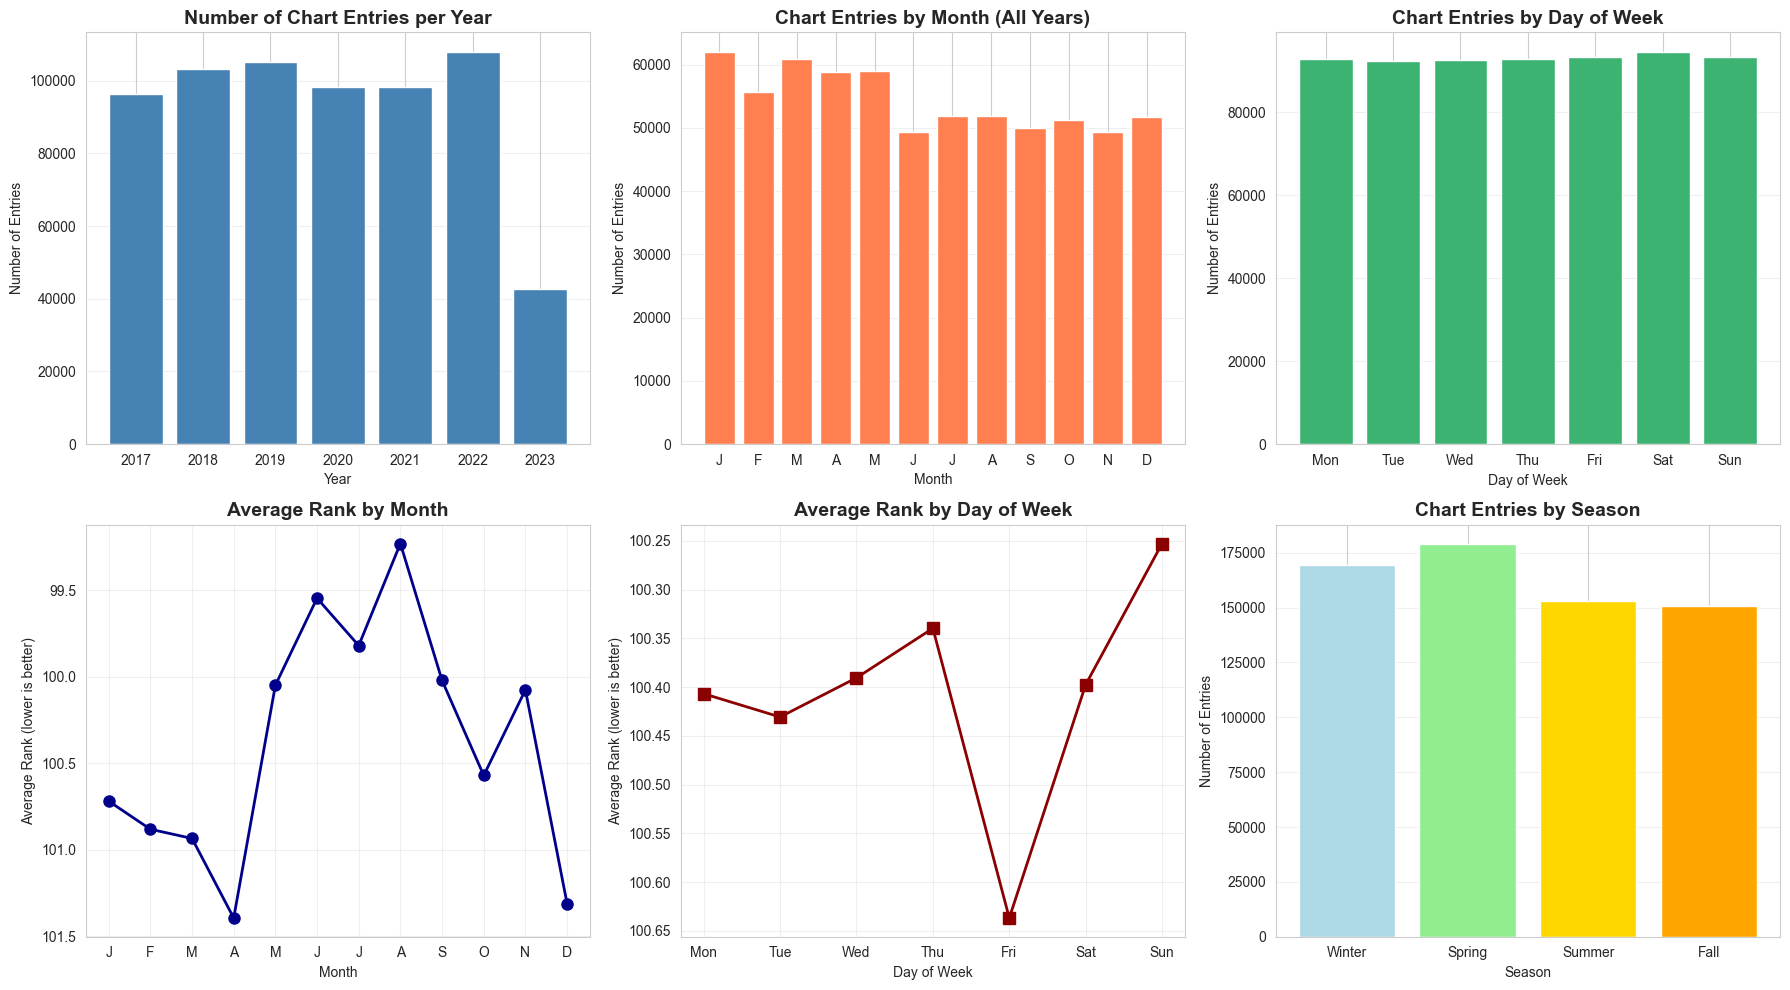


📊 KEY TEMPORAL INSIGHTS:
- Most popular release day: Saturday (94,569 entries)
- Least popular release day: Tuesday (92,476 entries)
- Best performing month (lowest avg rank): August
- Most active season: Spring


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Songs per Year
yearly_counts = df.groupby('Year').size()
axes[0, 0].bar(yearly_counts.index, yearly_counts.values, color='steelblue')
axes[0, 0].set_title('Number of Chart Entries per Year', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Entries')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Songs per Month (aggregated across all years)
monthly_counts = df.groupby('MonthName').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
axes[0, 1].bar(range(12), monthly_counts.values, color='coral')
axes[0, 1].set_title('Chart Entries by Month (All Years)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Entries')
axes[0, 1].set_xticks(range(12))
axes[0, 1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Songs per Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df.groupby('DayName').size().reindex(day_order)
axes[0, 2].bar(range(7), dow_counts.values, color='mediumseagreen')
axes[0, 2].set_title('Chart Entries by Day of Week', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Day of Week')
axes[0, 2].set_ylabel('Number of Entries')
axes[0, 2].set_xticks(range(7))
axes[0, 2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 2].grid(axis='y', alpha=0.3)

# Plot 4: Average Rank by Month
monthly_rank = df.groupby('MonthName')['Rank'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
axes[1, 0].plot(range(12), monthly_rank.values, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[1, 0].set_title('Average Rank by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Rank (lower is better)')
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[1, 0].grid(alpha=0.3)
axes[1, 0].invert_yaxis()  # Lower rank is better

# Plot 5: Average Rank by Day of Week
dow_rank = df.groupby('DayName')['Rank'].mean().reindex(day_order)
axes[1, 1].plot(range(7), dow_rank.values, marker='s', linewidth=2, markersize=8, color='darkred')
axes[1, 1].set_title('Average Rank by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Rank (lower is better)')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 1].grid(alpha=0.3)
axes[1, 1].invert_yaxis()

# Plot 6: Seasonal Patterns
seasonal_counts = df.groupby('Season').size().reindex(['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 2].bar(range(4), seasonal_counts.values, color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[1, 2].set_title('Chart Entries by Season', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Season')
axes[1, 2].set_ylabel('Number of Entries')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 KEY TEMPORAL INSIGHTS:")
print(f"- Most popular release day: {dow_counts.idxmax()} ({dow_counts.max():,} entries)")
print(f"- Least popular release day: {dow_counts.idxmin()} ({dow_counts.min():,} entries)")
print(f"- Best performing month (lowest avg rank): {monthly_rank.idxmin()}")
print(f"- Most active season: {seasonal_counts.idxmax()}")

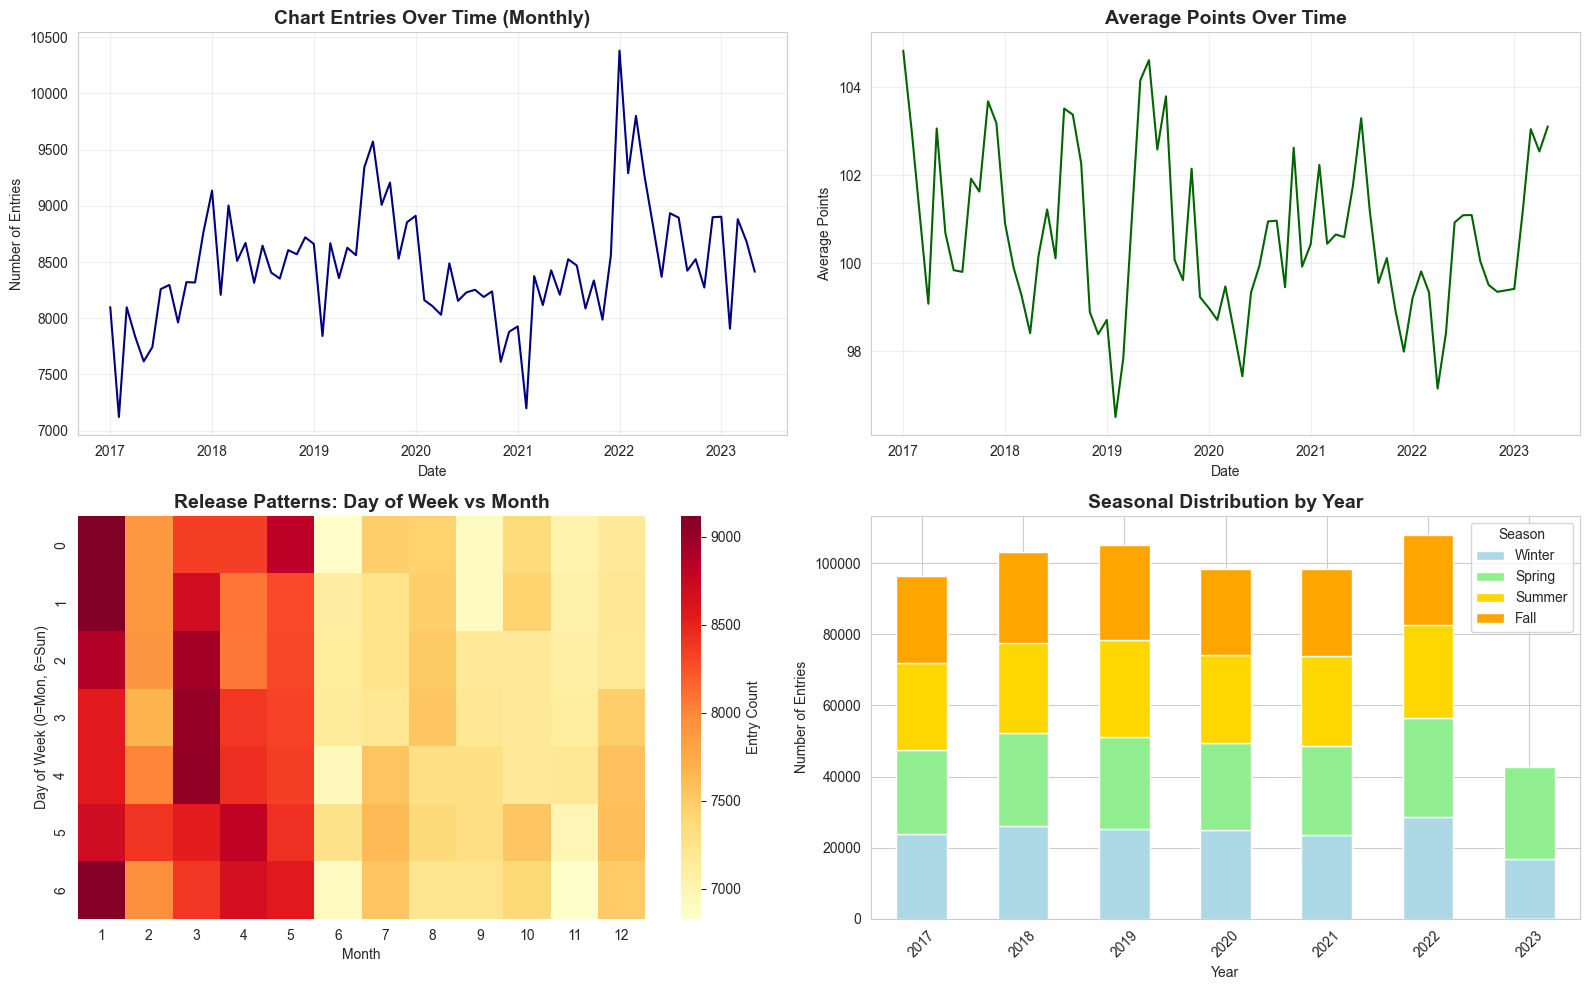

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Monthly time series of entries
monthly_ts = df.groupby(df['Date'].dt.to_period('M')).size()
monthly_ts.index = monthly_ts.index.to_timestamp()
axes[0, 0].plot(monthly_ts.index, monthly_ts.values, linewidth=1.5, color='navy')
axes[0, 0].set_title('Chart Entries Over Time (Monthly)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Entries')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Average Points over time
monthly_points = df.groupby(df['Date'].dt.to_period('M'))['Points (Total)'].mean()
monthly_points.index = monthly_points.index.to_timestamp()
axes[0, 1].plot(monthly_points.index, monthly_points.values, linewidth=1.5, color='darkgreen')
axes[0, 1].set_title('Average Points Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Average Points')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Heatmap - Day of Week vs Month
pivot_dow_month = df.groupby(['DayOfWeek', 'Month']).size().reset_index(name='count')
pivot_dow_month = pivot_dow_month.pivot(index='DayOfWeek', columns='Month', values='count')
sns.heatmap(pivot_dow_month, annot=False, cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Entry Count'})
axes[1, 0].set_title('Release Patterns: Day of Week vs Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Day of Week (0=Mon, 6=Sun)')

# Plot 4: Year vs Season patterns
pivot_year_season = df.groupby(['Year', 'Season']).size().reset_index(name='count')
pivot_year_season = pivot_year_season.pivot(index='Year', columns='Season', values='count')
pivot_year_season = pivot_year_season[['Winter', 'Spring', 'Summer', 'Fall']]  # Order seasons
pivot_year_season.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                       color=['lightblue', 'lightgreen', 'gold', 'orange'])
axes[1, 1].set_title('Seasonal Distribution by Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Entries')
axes[1, 1].legend(title='Season')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
print("\n" + "="*60)
print("PERFORMANCE METRICS ANALYSIS")
print("="*60)

# Basic statistics
print("\nRank Statistics:")
print(df['Rank'].describe())
print(f"\nTop 10 appearances: {(df['Rank'] <= 10).sum():,} ({(df['Rank'] <= 10).mean()*100:.1f}%)")
print(f"Top 50 appearances: {(df['Rank'] <= 50).sum():,} ({(df['Rank'] <= 50).mean()*100:.1f}%)")
print(f"Top 100 appearances: {(df['Rank'] <= 100).sum():,} ({(df['Rank'] <= 100).mean()*100:.1f}%)")

print("\nPoints Statistics:")
print(df['Points (Total)'].describe())


PERFORMANCE METRICS ANALYSIS

Rank Statistics:
count    651936.000000
mean        100.407782
std          57.406664
min           1.000000
25%          51.000000
50%         100.000000
75%         150.000000
max         200.000000
Name: Rank, dtype: float64

Top 10 appearances: 31,417 (4.8%)
Top 50 appearances: 160,965 (24.7%)
Top 100 appearances: 327,895 (50.3%)

Points Statistics:
count    651936.000000
mean        100.592218
std          57.406664
min           1.000000
25%          51.000000
50%         101.000000
75%         150.000000
max         200.000000
Name: Points (Total), dtype: float64


In [8]:
# Aggregate to song level for performance analysis
song_performance = df.groupby('id').agg({
    'Rank': ['min', 'mean', 'std', 'count'],
    'Points (Total)': ['sum', 'mean'],
    'Title': 'first',
    'Artists': 'first',
    'Date': ['min', 'max']
}).reset_index()

# Flatten column names
song_performance.columns = ['_'.join(col).strip('_') for col in song_performance.columns.values]
song_performance.columns = ['id', 'Best_Rank', 'Avg_Rank', 'Rank_Std', 'Chart_Weeks', 
                            'Total_Points', 'Avg_Points', 'Title', 'Artists', 
                            'First_Date', 'Last_Date']

# Calculate additional metrics
song_performance['Chart_Longevity_Days'] = (song_performance['Last_Date'] - song_performance['First_Date']).dt.days
song_performance['Peak_Performance'] = 201 - song_performance['Best_Rank']  # Higher is better
song_performance['Consistency'] = 1 / (song_performance['Rank_Std'] + 1)  # High consistency = low std

# Categorize performance
song_performance['Top10_Weeks'] = df[df['Rank'] <= 10].groupby('id').size()
song_performance['Top50_Weeks'] = df[df['Rank'] <= 50].groupby('id').size()
song_performance['Top10_Weeks'] = song_performance['Top10_Weeks'].fillna(0)
song_performance['Top50_Weeks'] = song_performance['Top50_Weeks'].fillna(0)

print("\n" + "="*60)
print("SONG-LEVEL PERFORMANCE STATISTICS")
print("="*60)
print(f"Total unique songs: {len(song_performance):,}")
print(f"\nChart Weeks Distribution:")
print(song_performance['Chart_Weeks'].describe())
print(f"\nSongs with 1 week only: {(song_performance['Chart_Weeks'] == 1).sum():,} ({(song_performance['Chart_Weeks'] == 1).mean()*100:.1f}%)")
print(f"Songs with 5+ weeks: {(song_performance['Chart_Weeks'] >= 5).sum():,} ({(song_performance['Chart_Weeks'] >= 5).mean()*100:.1f}%)")
print(f"Songs with 10+ weeks: {(song_performance['Chart_Weeks'] >= 10).sum():,} ({(song_performance['Chart_Weeks'] >= 10).mean()*100:.1f}%)")
print(f"Songs with 20+ weeks: {(song_performance['Chart_Weeks'] >= 20).sum():,} ({(song_performance['Chart_Weeks'] >= 20).mean()*100:.1f}%)")

# Save for later use
song_performance.to_csv('song_performance_metrics.csv', index=False)
print("\nSong performance metrics saved!")


SONG-LEVEL PERFORMANCE STATISTICS
Total unique songs: 9,161

Chart Weeks Distribution:
count    9161.000000
mean       71.164283
std       172.927156
min         1.000000
25%         2.000000
50%         9.000000
75%        56.000000
max      2602.000000
Name: Chart_Weeks, dtype: float64

Songs with 1 week only: 1,783 (19.5%)
Songs with 5+ weeks: 5,761 (62.9%)
Songs with 10+ weeks: 4,542 (49.6%)
Songs with 20+ weeks: 3,621 (39.5%)

Song performance metrics saved!


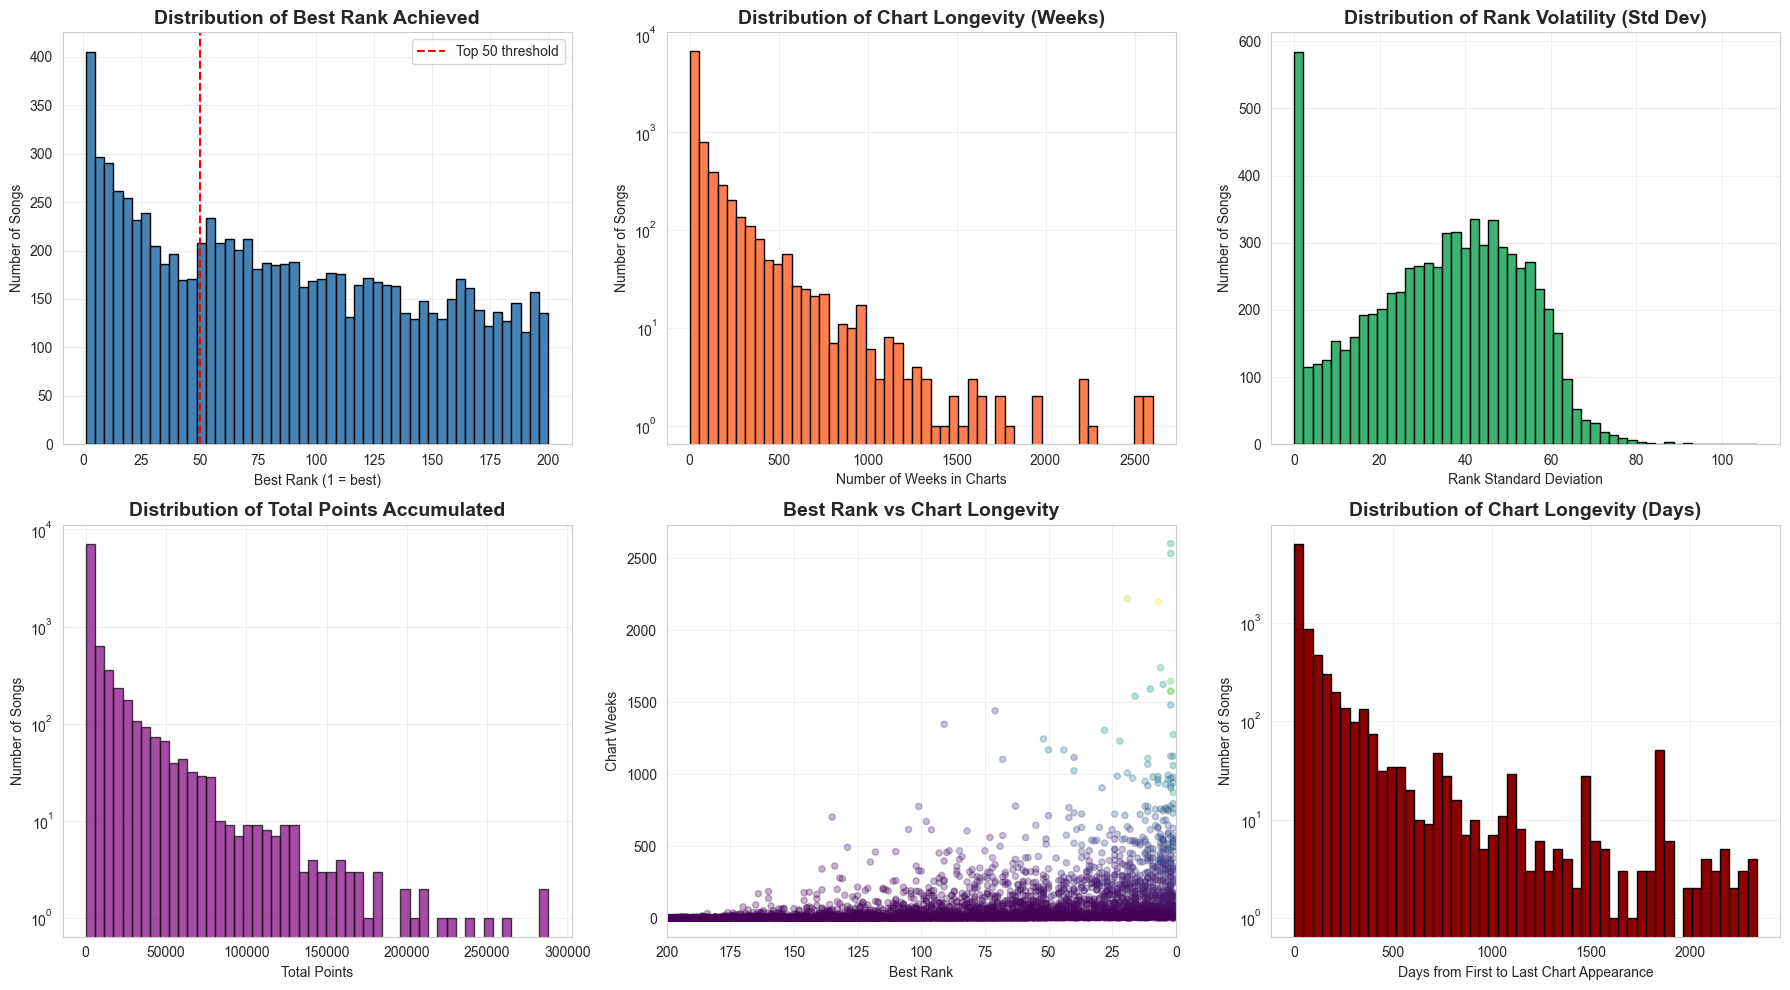

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Best Rank Distribution
axes[0, 0].hist(song_performance['Best_Rank'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Best Rank Achieved', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Best Rank (1 = best)')
axes[0, 0].set_ylabel('Number of Songs')
axes[0, 0].axvline(50, color='red', linestyle='--', label='Top 50 threshold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Chart Weeks Distribution (log scale)
axes[0, 1].hist(song_performance['Chart_Weeks'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Chart Longevity (Weeks)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Weeks in Charts')
axes[0, 1].set_ylabel('Number of Songs')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Rank Volatility
axes[0, 2].hist(song_performance['Rank_Std'].dropna(), bins=50, color='mediumseagreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Rank Volatility (Std Dev)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Rank Standard Deviation')
axes[0, 2].set_ylabel('Number of Songs')
axes[0, 2].grid(alpha=0.3)

# Plot 4: Total Points
axes[1, 0].hist(song_performance['Total_Points'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Total Points Accumulated', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Points')
axes[1, 0].set_ylabel('Number of Songs')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 5: Best Rank vs Chart Weeks (scatter)
sample = song_performance.sample(min(5000, len(song_performance)))
axes[1, 1].scatter(sample['Best_Rank'], sample['Chart_Weeks'], 
                   alpha=0.3, s=20, c=sample['Total_Points'], cmap='viridis')
axes[1, 1].set_title('Best Rank vs Chart Longevity', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Best Rank')
axes[1, 1].set_ylabel('Chart Weeks')
axes[1, 1].set_xlim(0, 200)
axes[1, 1].invert_xaxis()
axes[1, 1].grid(alpha=0.3)

# Plot 6: Chart Longevity Days
axes[1, 2].hist(song_performance['Chart_Longevity_Days'], bins=50, color='darkred', edgecolor='black')
axes[1, 2].set_title('Distribution of Chart Longevity (Days)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Days from First to Last Chart Appearance')
axes[1, 2].set_ylabel('Number of Songs')
axes[1, 2].set_yscale('log')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

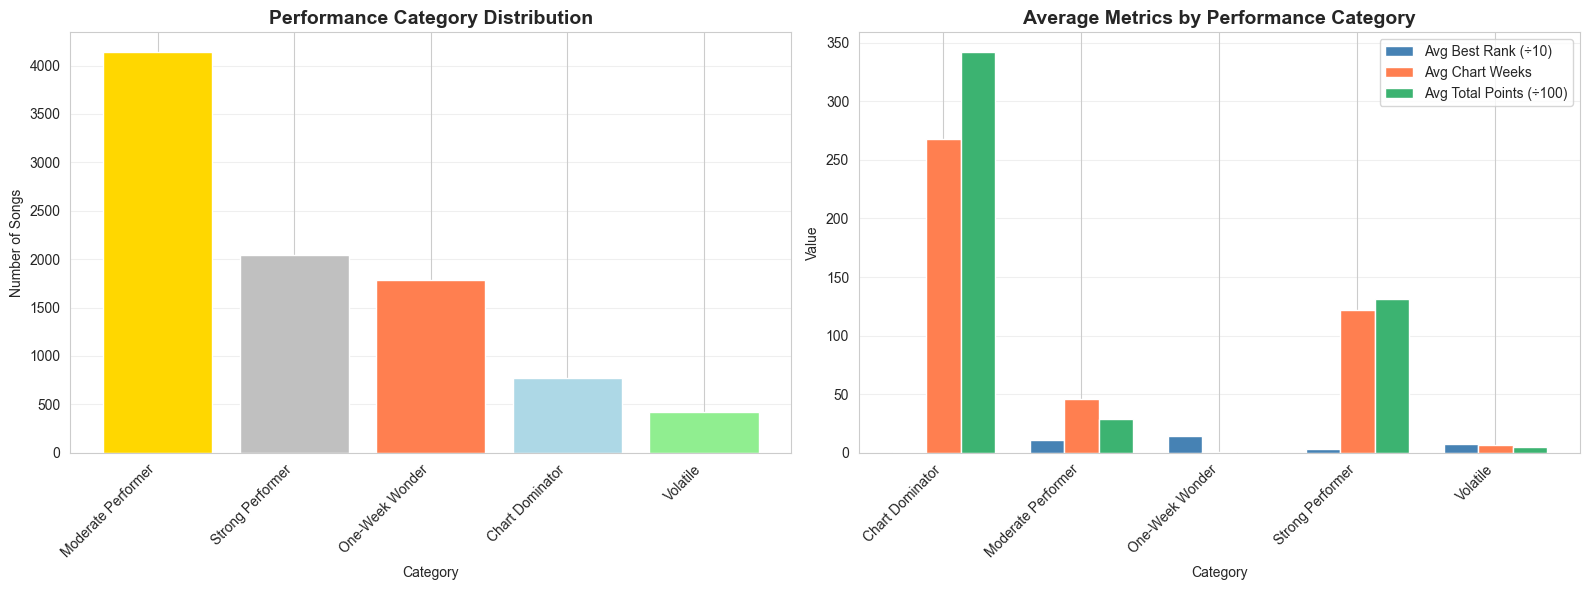


Performance Category Breakdown:
Performance_Category
Moderate Performer    4136
Strong Performer      2043
One-Week Wonder       1783
Chart Dominator        776
Volatile               423
Name: count, dtype: int64


In [10]:
# Create performance categories for visualization
def categorize_performance(row):
    if row['Best_Rank'] <= 10 and row['Chart_Weeks'] >= 10:
        return 'Chart Dominator'
    elif row['Best_Rank'] <= 50 and row['Chart_Weeks'] >= 5:
        return 'Strong Performer'
    elif row['Chart_Weeks'] == 1:
        return 'One-Week Wonder'
    elif row['Rank_Std'] > 50:
        return 'Volatile'
    else:
        return 'Moderate Performer'

song_performance['Performance_Category'] = song_performance.apply(categorize_performance, axis=1)

# Visualize categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category distribution
category_counts = song_performance['Performance_Category'].value_counts()
axes[0].bar(range(len(category_counts)), category_counts.values, 
            color=['gold', 'silver', 'coral', 'lightblue', 'lightgreen'])
axes[0].set_title('Performance Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Songs')
axes[0].set_xticks(range(len(category_counts)))
axes[0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Category characteristics
category_stats = song_performance.groupby('Performance_Category').agg({
    'Best_Rank': 'mean',
    'Chart_Weeks': 'mean',
    'Total_Points': 'mean'
})

x = np.arange(len(category_stats))
width = 0.25

axes[1].bar(x - width, category_stats['Best_Rank']/10, width, label='Avg Best Rank (÷10)', color='steelblue')
axes[1].bar(x, category_stats['Chart_Weeks'], width, label='Avg Chart Weeks', color='coral')
axes[1].bar(x + width, category_stats['Total_Points']/100, width, label='Avg Total Points (÷100)', color='mediumseagreen')

axes[1].set_title('Average Metrics by Performance Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Value')
axes[1].set_xticks(x)
axes[1].set_xticklabels(category_stats.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('performance_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPerformance Category Breakdown:")
print(category_counts)

In [11]:
print("\n" + "="*60)
print("TEMPORAL/ERA CLUSTERING - FEATURE ENGINEERING")
print("="*60)

# Create song-level temporal features
temporal_features = df.groupby('id').agg({
    'Date': ['min', 'max'],  # First and last appearance
    'Year': 'first',
    'Month': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Season': 'first',
    'Quarter': 'first',
    'Title': 'first',
    'Artists': 'first'
}).reset_index()

# Flatten columns
temporal_features.columns = ['_'.join(col).strip('_') for col in temporal_features.columns.values]
temporal_features.columns = ['id', 'First_Date', 'Last_Date', 'Year', 'Month', 
                             'DayOfWeek', 'IsWeekend', 'Season', 'Quarter',
                             'Title', 'Artists']

# Merge with song performance for additional context
temporal_features = temporal_features.merge(
    song_performance[['id', 'Chart_Weeks', 'Chart_Longevity_Days', 'Best_Rank']],
    on='id',
    how='left'
)

# Calculate temporal behavior features
temporal_features['Days_In_Charts'] = (temporal_features['Last_Date'] - temporal_features['First_Date']).dt.days
temporal_features['Weeks_Per_Day_Ratio'] = temporal_features['Chart_Weeks'] / (temporal_features['Days_In_Charts'] + 1)

# Peak timing - how fast did it peak? (proxy: if Best_Rank is very good and Chart_Weeks is low, it peaked fast)
temporal_features['Quick_Peak_Score'] = (201 - temporal_features['Best_Rank']) / (temporal_features['Chart_Weeks'] + 1)

# Longevity type
temporal_features['Sustained_Presence'] = (temporal_features['Chart_Weeks'] >= 10).astype(int)
temporal_features['Brief_Appearance'] = (temporal_features['Chart_Weeks'] <= 2).astype(int)

# Encode cyclical features (month, day of week)
temporal_features['Month_Sin'] = np.sin(2 * np.pi * temporal_features['Month'] / 12)
temporal_features['Month_Cos'] = np.cos(2 * np.pi * temporal_features['Month'] / 12)
temporal_features['DayOfWeek_Sin'] = np.sin(2 * np.pi * temporal_features['DayOfWeek'] / 7)
temporal_features['DayOfWeek_Cos'] = np.cos(2 * np.pi * temporal_features['DayOfWeek'] / 7)

# Encode season
season_dummies = pd.get_dummies(temporal_features['Season'], prefix='Season')
temporal_features = pd.concat([temporal_features, season_dummies], axis=1)

print(f"Temporal features created for {len(temporal_features):,} songs")
print(f"\nFeature columns: {temporal_features.shape[1]}")


TEMPORAL/ERA CLUSTERING - FEATURE ENGINEERING
Temporal features created for 9,161 songs

Feature columns: 27


In [12]:
# Select numerical features for clustering
temporal_clustering_features = [
    'Year',
    'Month_Sin', 'Month_Cos',
    'DayOfWeek_Sin', 'DayOfWeek_Cos',
    'IsWeekend',
    'Quarter',
    'Chart_Weeks',
    'Days_In_Charts',
    'Weeks_Per_Day_Ratio',
    'Quick_Peak_Score',
    'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter'
]

X_temporal = temporal_features[temporal_clustering_features].copy()

# Handle any missing values
X_temporal = X_temporal.fillna(X_temporal.median())

# Check for infinite values
X_temporal = X_temporal.replace([np.inf, -np.inf], np.nan)
X_temporal = X_temporal.fillna(X_temporal.median())

print("\nFeatures selected for temporal clustering:")
for i, feat in enumerate(temporal_clustering_features, 1):
    print(f"{i}. {feat}")

print(f"\nData's shape for clustering: {X_temporal.shape}")
print(f"Missing values: {X_temporal.isnull().sum().sum()}")


Features selected for temporal clustering:
1. Year
2. Month_Sin
3. Month_Cos
4. DayOfWeek_Sin
5. DayOfWeek_Cos
6. IsWeekend
7. Quarter
8. Chart_Weeks
9. Days_In_Charts
10. Weeks_Per_Day_Ratio
11. Quick_Peak_Score
12. Season_Fall
13. Season_Spring
14. Season_Summer
15. Season_Winter

Data's shape for clustering: (9161, 15)
Missing values: 0


Finding optimal number of clusters:
K=3: Inertia=96649.03, Silhouette=0.228, Davies-Bouldin=1.659
K=4: Inertia=80712.57, Silhouette=0.283, Davies-Bouldin=1.477
K=5: Inertia=73180.12, Silhouette=0.294, Davies-Bouldin=1.376
K=6: Inertia=69355.23, Silhouette=0.272, Davies-Bouldin=1.371
K=7: Inertia=65179.70, Silhouette=0.276, Davies-Bouldin=1.454
K=8: Inertia=62478.40, Silhouette=0.248, Davies-Bouldin=1.612
K=9: Inertia=59271.28, Silhouette=0.263, Davies-Bouldin=1.544
K=10: Inertia=56304.69, Silhouette=0.282, Davies-Bouldin=1.415


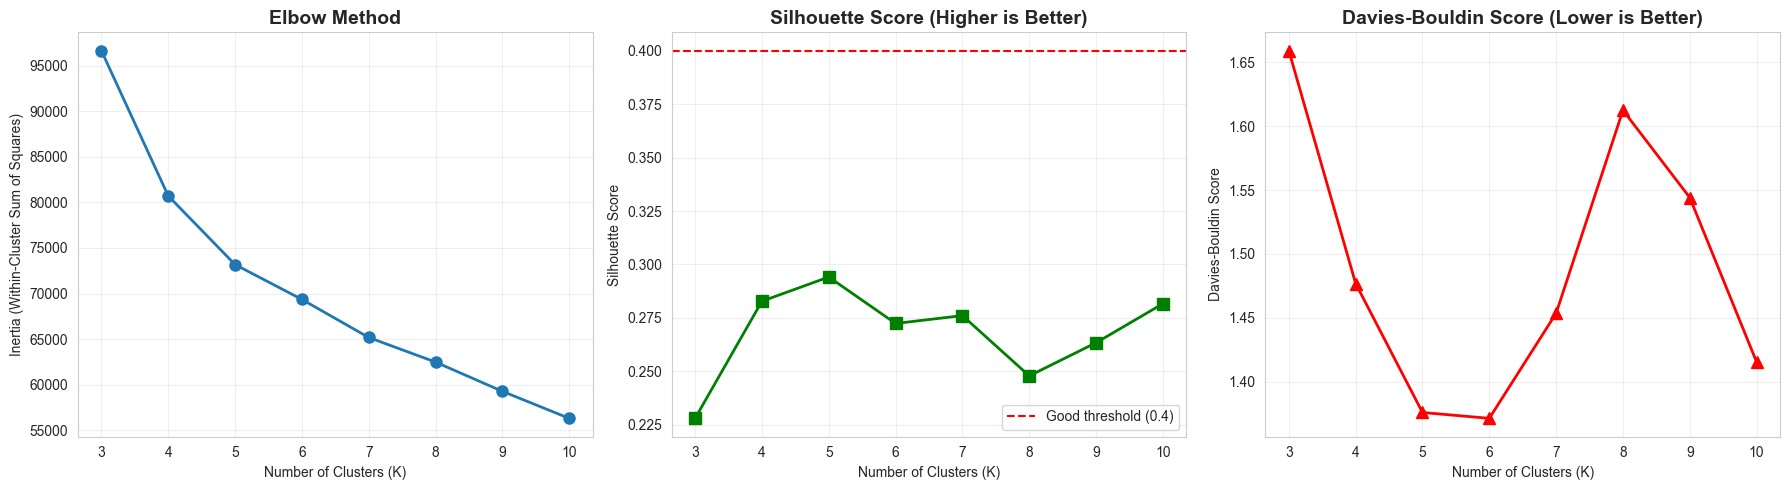


Recommendations:
- Best K by Silhouette Score: 5
- Best K by Davies-Bouldin: 6
- Suggested K for temporal clustering: 5-6 (balance interpretability and quality)


In [13]:
# Scale features
scaler_temporal = StandardScaler()
X_temporal_scaled = scaler_temporal.fit_transform(X_temporal)

print("Finding optimal number of clusters:")

# Test different numbers of clusters
k_range = range(3, 11)
inertias = []
silhouette_scores = []
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_temporal_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_temporal_scaled, labels))
    db_scores.append(davies_bouldin_score(X_temporal_scaled, labels))
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={db_scores[-1]:.3f}")

# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].grid(alpha=0.3)

# Silhouette score (higher is better)
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].axhline(0.4, color='red', linestyle='--', label='Good threshold (0.4)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin score (lower is better)
axes[2].plot(k_range, db_scores, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Recommend K
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f"\nRecommendations:")
print(f"- Best K by Silhouette Score: {best_k_silhouette}")
print(f"- Best K by Davies-Bouldin: {best_k_db}")
print(f"- Suggested K for temporal clustering: 5-6 (balance interpretability and quality)")

In [14]:
# Choose optimal K (6 for good balance)
optimal_k_temporal = 6

print(f"\n🎯 Performing K-Means clustering with K={optimal_k_temporal}")

# Final clustering
kmeans_temporal = KMeans(n_clusters=optimal_k_temporal, random_state=42, n_init=20, max_iter=500)
temporal_features['Temporal_Cluster'] = kmeans_temporal.fit_predict(X_temporal_scaled)

# Add cluster labels to original dataframe
df = df.merge(
    temporal_features[['id', 'Temporal_Cluster']],
    on='id',
    how='left'
)

print(f"Temporal clustering done")
print(f"\nCluster distribution:")
print(temporal_features['Temporal_Cluster'].value_counts().sort_index())


🎯 Performing K-Means clustering with K=6
Temporal clustering done

Cluster distribution:
Temporal_Cluster
0     217
1    2512
2    2037
3     241
4    2030
5    2124
Name: count, dtype: int64


In [16]:
# Analyze each cluster
cluster_profiles = temporal_features.groupby('Temporal_Cluster').agg({
    'Year': 'mean',
    'Month': 'mean',
    'DayOfWeek': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean(),
    'IsWeekend': 'mean',
    'Chart_Weeks': 'mean',
    'Days_In_Charts': 'mean',
    'Weeks_Per_Day_Ratio': 'mean',
    'Quick_Peak_Score': 'mean',
    'Season_Fall': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'id': 'count'
}).round(2)

cluster_profiles.columns = ['Avg_Year', 'Avg_Month', 'Mode_DayOfWeek', 'Weekend_Rate',
                            'Avg_Chart_Weeks', 'Avg_Days_In_Charts', 'Avg_Weeks_Per_Day',
                            'Avg_Quick_Peak', 'Fall_Rate', 'Spring_Rate', 'Summer_Rate',
                            'Winter_Rate', 'Cluster_Size']

print("\nCluster Profiles:")
print(cluster_profiles)

def name_temporal_cluster_statistical(cluster_id, profile, all_profiles):
    """
    Name clusters by comparing to ALL other clusters, not just overall average
    This creates more distinctive names
    """
    
    # Calculate percentile ranks for each metric across all clusters
    metrics = {
        'Year': profile['Avg_Year'],
        'Chart_Weeks': profile['Avg_Chart_Weeks'],
        'Weekend_Rate': profile['Weekend_Rate'],
        'Quick_Peak': profile['Avg_Quick_Peak'],
        'Weeks_Per_Day': profile['Avg_Weeks_Per_Day']
    }
    
    # Rank this cluster on each metric (0 = lowest, n-1 = highest)
    ranks = {}
    for metric in ['Avg_Year', 'Avg_Chart_Weeks', 'Weekend_Rate', 'Avg_Quick_Peak', 'Avg_Weeks_Per_Day']:
        cluster_values = all_profiles[metric].values
        cluster_rank = np.where(np.sort(cluster_values) == profile[metric])[0][0]
        ranks[metric] = cluster_rank
    
    # Get season info
    season_cols = ['Fall_Rate', 'Spring_Rate', 'Summer_Rate', 'Winter_Rate']
    seasons = ['Fall', 'Spring', 'Summer', 'Winter']
    season_values = [profile['Fall_Rate'], profile['Spring_Rate'], 
                     profile['Summer_Rate'], profile['Winter_Rate']]
    dominant_season_idx = np.argmax(season_values)
    dominant_season = seasons[dominant_season_idx]
    dominant_season_strength = season_values[dominant_season_idx]
    
    # Get month name
    avg_month = int(profile['Avg_Month'])
    month_name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][avg_month-1]
    
    # Decision logic based on distinctive features
    name_parts = []
    
    # 1. Temporal era (if it's distinctively early or late)
    n_clusters = len(all_profiles)
    if ranks['Avg_Year'] <= 1:  # One of the two earliest
        name_parts.append("Early Era (2017-2018)")
    elif ranks['Avg_Year'] >= n_clusters - 2:  # One of the two latest
        name_parts.append("Recent Era (2022-2023)")
    
    # 2. Performance pattern (if distinctive)
    if ranks['Avg_Chart_Weeks'] >= n_clusters - 1:  # Longest
        if ranks['Avg_Weeks_Per_Day'] >= n_clusters - 2:  # Also concentrated
            name_parts.append("Sustained Success")
        else:
            name_parts.append("Slow Burn Hit")
    elif ranks['Avg_Chart_Weeks'] <= 1:  # Shortest
        if ranks['Avg_Quick_Peak'] >= n_clusters - 2:  # But high peak
            name_parts.append("Viral/Quick Peak")
        else:
            name_parts.append("Brief Charting")
    
    # 3. Seasonal pattern (if strong - >40%)
    if dominant_season_strength > 0.4:
        if dominant_season == 'Winter' and avg_month in [11, 12, 1]:
            name_parts.append("Holiday/Winter")
        elif dominant_season == 'Summer' and avg_month in [6, 7, 8]:
            name_parts.append("Summer")
        else:
            name_parts.append(f"{dominant_season}")
    
    # 4. Release pattern (if distinctive)
    if profile['Weekend_Rate'] > 0.3 and ranks['Weekend_Rate'] >= n_clusters - 2:
        name_parts.append("Weekend Release")
    elif profile['Mode_DayOfWeek'] == 4:  # Friday
        if not name_parts or len(name_parts) == 1:  # Only add if not much else
            name_parts.append("Friday Fresh")
    
    # Construct final name (use up to 2 components for readability)
    if len(name_parts) == 0:
        # Fallback: use most distinctive feature
        final_name = f"{dominant_season} - {month_name} Avg"
    elif len(name_parts) == 1:
        final_name = name_parts[0]
    else:
        # Combine most important parts
        final_name = " - ".join(name_parts[:2])
    
    return final_name

# Apply statistical naming
cluster_names_statistical = {}

print("\n" + "="*60)
print("STATISTICAL NAMING APPROACH")
print("="*60)

for cluster_id in range(optimal_k_temporal):
    profile = cluster_profiles.loc[cluster_id]
    name = name_temporal_cluster_statistical(cluster_id, profile, cluster_profiles)
    cluster_names_statistical[cluster_id] = name
    
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  Size: {profile['Cluster_Size']:.0f} songs")
    print(f"  Year: {profile['Avg_Year']:.1f}")
    print(f"  Chart Weeks: {profile['Avg_Chart_Weeks']:.1f}")
    print(f"  Weekend Rate: {profile['Weekend_Rate']*100:.1f}%")

# Apply to dataframes
temporal_features['Temporal_Cluster_Name'] = temporal_features['Temporal_Cluster'].map(cluster_names_statistical)
df['Temporal_Cluster_Name'] = df['Temporal_Cluster'].map(cluster_names_statistical)

print("\nStatistical naming complete!")
print("\nFinal cluster names:")
for cid, name in cluster_names_statistical.items():
    print(f"  Cluster {cid}: {name}")


Cluster Profiles:
                  Avg_Year  Avg_Month  Mode_DayOfWeek  Weekend_Rate  \
Temporal_Cluster                                                      
0                  2021.81       9.52               6          0.49   
1                  2020.12       4.10               4          0.20   
2                  2019.79       5.10               4          0.25   
3                  2021.20       5.04               0          0.34   
4                  2019.49      10.06               4          0.19   
5                  2019.38       6.99               4          0.21   

                  Avg_Chart_Weeks  Avg_Days_In_Charts  Avg_Weeks_Per_Day  \
Temporal_Cluster                                                           
0                          125.44             1368.24               0.10   
1                           51.34               48.26               1.21   
2                           46.74               59.27               1.14   
3                          867.3

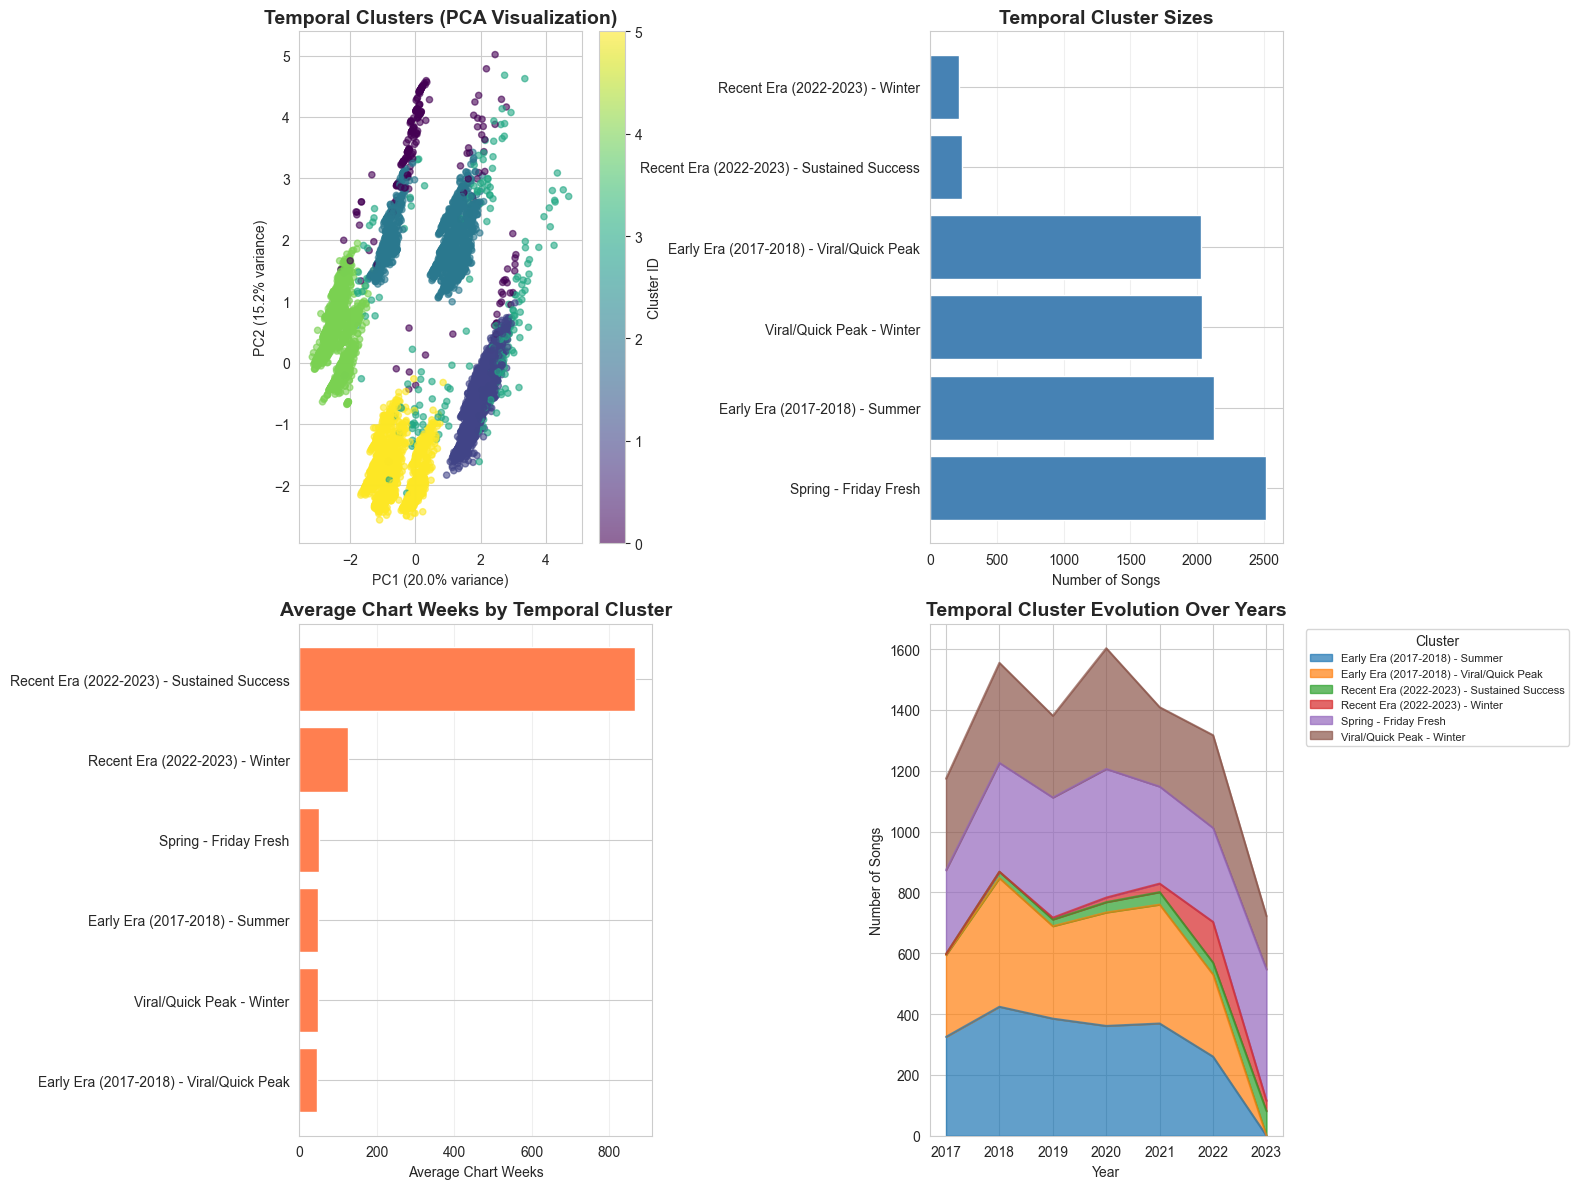

In [17]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_temporal_pca = pca.fit_transform(X_temporal_scaled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PCA visualization
scatter = axes[0, 0].scatter(X_temporal_pca[:, 0], X_temporal_pca[:, 1], 
                             c=temporal_features['Temporal_Cluster'], 
                             cmap='viridis', alpha=0.6, s=20)
axes[0, 0].set_title('Temporal Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster ID')

# Plot 2: Cluster size
cluster_sizes = temporal_features['Temporal_Cluster_Name'].value_counts()
axes[0, 1].barh(range(len(cluster_sizes)), cluster_sizes.values, color='steelblue')
axes[0, 1].set_yticks(range(len(cluster_sizes)))
axes[0, 1].set_yticklabels(cluster_sizes.index)
axes[0, 1].set_title('Temporal Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Songs')
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Cluster characteristics - Average Chart Weeks
cluster_char = temporal_features.groupby('Temporal_Cluster_Name')['Chart_Weeks'].mean().sort_values()
axes[1, 0].barh(range(len(cluster_char)), cluster_char.values, color='coral')
axes[1, 0].set_yticks(range(len(cluster_char)))
axes[1, 0].set_yticklabels(cluster_char.index)
axes[1, 0].set_title('Average Chart Weeks by Temporal Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Chart Weeks')
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Temporal distribution over years
pivot_year_cluster = temporal_features.groupby(['Year', 'Temporal_Cluster_Name']).size().reset_index(name='count')
pivot_year_cluster = pivot_year_cluster.pivot(index='Year', columns='Temporal_Cluster_Name', values='count').fillna(0)
pivot_year_cluster.plot(kind='area', stacked=True, ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Temporal Cluster Evolution Over Years', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Songs')
axes[1, 1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('temporal_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Save temporal features with clusters
temporal_features.to_csv('temporal_features_with_clusters.csv', index=False)

# Save cluster centroids for future assignment
centroids_temporal = pd.DataFrame(
    scaler_temporal.inverse_transform(kmeans_temporal.cluster_centers_),
    columns=temporal_clustering_features
)
centroids_temporal['Cluster_Name'] = centroids_temporal.index.map(cluster_names_statistical)
centroids_temporal.to_csv('temporal_cluster_centroids.csv', index=False)

print("\nTemporal clustering results saved!")
print(f"- temporal_features_with_clusters.csv")
print(f"- temporal_cluster_centroids.csv")


Temporal clustering results saved!
- temporal_features_with_clusters.csv
- temporal_cluster_centroids.csv


In [20]:
print("\n" + "="*60)
print("PERFORMANCE PATTERN CLUSTERING - FEATURE ENGINEERING")
print("="*60)


performance_features = song_performance.copy()

# Performance intensity metrics
performance_features['Top10_Rate'] = performance_features['Top10_Weeks'] / performance_features['Chart_Weeks']
performance_features['Top50_Rate'] = performance_features['Top50_Weeks'] / performance_features['Chart_Weeks']

# Rank range (difference between best and worst)
# Need to get worst rank for each song
worst_ranks = df.groupby('id')['Rank'].max().reset_index()
worst_ranks.columns = ['id', 'Worst_Rank']
performance_features = performance_features.merge(worst_ranks, on='id', how='left')

performance_features['Rank_Range'] = performance_features['Worst_Rank'] - performance_features['Best_Rank']

# Volatility score (normalized)
performance_features['Volatility_Score'] = performance_features['Rank_Std'] / performance_features['Avg_Rank']

# Success intensity (points per week)
performance_features['Points_Per_Week'] = performance_features['Total_Points'] / performance_features['Chart_Weeks']

# Dominance score (combine peak and longevity)
performance_features['Dominance_Score'] = (201 - performance_features['Best_Rank']) * np.log1p(performance_features['Chart_Weeks'])

# Consistency score (inverse of volatility, normalized)
performance_features['Consistency_Score'] = 1 / (1 + performance_features['Rank_Std'])

# Chart trajectory
first_ranks = df.sort_values('Date').groupby('id').first()['Rank'].reset_index()
first_ranks.columns = ['id', 'First_Week_Rank']
last_ranks = df.sort_values('Date').groupby('id').last()['Rank'].reset_index()
last_ranks.columns = ['id', 'Last_Week_Rank']

performance_features = performance_features.merge(first_ranks, on='id', how='left')
performance_features = performance_features.merge(last_ranks, on='id', how='left')

performance_features['Rank_Trajectory'] = performance_features['First_Week_Rank'] - performance_features['Last_Week_Rank']  # Positive = improved

# Time to peak (how many weeks to reach best rank)
def calculate_weeks_to_peak(song_id, df_orig):
    song_data = df_orig[df_orig['id'] == song_id].sort_values('Date')
    best_rank = song_data['Rank'].min()
    weeks_to_peak = (song_data[song_data['Rank'] == best_rank].iloc[0]['Date'] - song_data.iloc[0]['Date']).days / 7
    return max(0, weeks_to_peak)

# This is computationally expensive, so sample or use a simplified version
performance_features['Weeks_To_Peak'] = performance_features['Chart_Weeks'] / 2  # Simplified: assume peak at midpoint

print(f"Performance features created for {len(performance_features):,} songs")
print(f"\nFeature columns: {performance_features.shape[1]}")


PERFORMANCE PATTERN CLUSTERING - FEATURE ENGINEERING
Performance features created for 9,161 songs

Feature columns: 29


In [21]:
# Avoid Data Leakage
# Only use features available AFTER the song has completed its chart run
# For prediction tasks, we'd need to be more careful
# Here, we're describing patterns, so we can use outcome-based features

performance_clustering_features = [
    'Best_Rank',
    'Avg_Rank',
    'Rank_Std',
    'Chart_Weeks',
    'Total_Points',
    'Points_Per_Week',
    'Top10_Rate',
    'Top50_Rate',
    'Rank_Range',
    'Volatility_Score',
    'Dominance_Score',
    'Consistency_Score',
    'Rank_Trajectory'
]

X_performance = performance_features[performance_clustering_features].copy()

# Handle missing/infinite values
X_performance = X_performance.replace([np.inf, -np.inf], np.nan)
X_performance = X_performance.fillna(X_performance.median())

print("\nFeatures selected for performance clustering:")
for i, feat in enumerate(performance_clustering_features, 1):
    print(f"{i}. {feat}")

print(f"\nData shape for clustering: {X_performance.shape}")
print(f"Any missing values: {X_performance.isnull().sum().sum()}")

# Check for outliers (optional: you might want to clip extreme values)
print("\nFeature statistics:")
print(X_performance.describe())


Features selected for performance clustering:
1. Best_Rank
2. Avg_Rank
3. Rank_Std
4. Chart_Weeks
5. Total_Points
6. Points_Per_Week
7. Top10_Rate
8. Top50_Rate
9. Rank_Range
10. Volatility_Score
11. Dominance_Score
12. Consistency_Score
13. Rank_Trajectory

Data shape for clustering: (9161, 13)
Any missing values: 0

Feature statistics:
         Best_Rank     Avg_Rank     Rank_Std  Chart_Weeks   Total_Points  \
count  9161.000000  9161.000000  9161.000000  9161.000000    9161.000000   
mean     87.258160   125.453279    34.433567    71.164283    7158.573082   
std      58.544799    43.212389    16.915481   172.927156   19182.912310   
min       1.000000     1.000000     0.000000     1.000000       1.000000   
25%      35.000000    96.474359    24.584383     2.000000     107.000000   
50%      81.000000   128.428571    35.957184     9.000000     661.000000   
75%     135.000000   159.000000    45.632921    56.000000    4493.000000   
max     200.000000   200.000000   108.187338  2602.


FINDING OPTIMAL NUMBER OF CLUSTERS (PERFORMANCE)
K=3: Inertia=53097.22, Silhouette=0.336, Davies-Bouldin=1.144
K=4: Inertia=43273.62, Silhouette=0.366, Davies-Bouldin=0.982
K=5: Inertia=36033.68, Silhouette=0.389, Davies-Bouldin=0.994
K=6: Inertia=31003.62, Silhouette=0.323, Davies-Bouldin=1.016
K=7: Inertia=27758.74, Silhouette=0.323, Davies-Bouldin=1.014
K=8: Inertia=25379.08, Silhouette=0.309, Davies-Bouldin=1.005
K=9: Inertia=23320.34, Silhouette=0.319, Davies-Bouldin=1.026
K=10: Inertia=21505.97, Silhouette=0.333, Davies-Bouldin=0.998


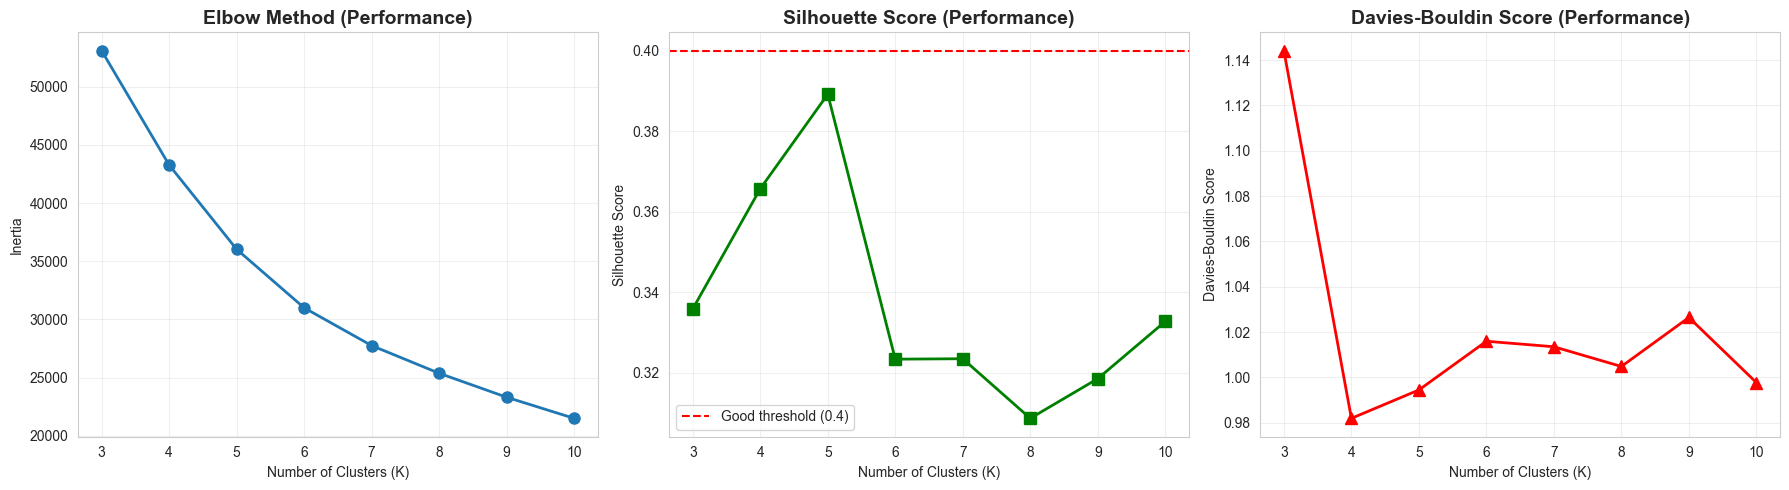


RECOMMENDATIONS:
- Best K by Silhouette Score: 5
- Best K by Davies-Bouldin: 4
- Suggested K for performance clustering: 5 (balance interpretability and quality)


In [22]:
# Scale features
scaler_performance = StandardScaler()
X_performance_scaled = scaler_performance.fit_transform(X_performance)

print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS (PERFORMANCE)")
print("="*60)

# Testing different numbers of clusters
k_range_perf = range(3, 11)
inertias_perf = []
silhouette_scores_perf = []
db_scores_perf = []

for k in k_range_perf:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_performance_scaled)
    
    inertias_perf.append(kmeans.inertia_)
    silhouette_scores_perf.append(silhouette_score(X_performance_scaled, labels))
    db_scores_perf.append(davies_bouldin_score(X_performance_scaled, labels))
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_perf[-1]:.3f}, Davies-Bouldin={db_scores_perf[-1]:.3f}")

# Visualizing metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range_perf, inertias_perf, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method (Performance)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(alpha=0.3)

# Silhouette score
axes[1].plot(k_range_perf, silhouette_scores_perf, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score (Performance)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].axhline(0.4, color='red', linestyle='--', label='Good threshold (0.4)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin score
axes[2].plot(k_range_perf, db_scores_perf, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_title('Davies-Bouldin Score (Performance)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Recommend K
best_k_silhouette_perf = k_range_perf[np.argmax(silhouette_scores_perf)]
best_k_db_perf = k_range_perf[np.argmin(db_scores_perf)]

print(f"\nRECOMMENDATIONS:")
print(f"- Best K by Silhouette Score: {best_k_silhouette_perf}")
print(f"- Best K by Davies-Bouldin: {best_k_db_perf}")
print(f"- Suggested K for performance clustering: 5 (balance interpretability and quality)")

In [30]:
optimal_k_performance = 4

print(f"\nPerforming K-Means clustering with K={optimal_k_performance}")

# Final clustering
kmeans_performance = KMeans(n_clusters=optimal_k_performance, random_state=42, n_init=20, max_iter=500)
performance_features['Performance_Cluster'] = kmeans_performance.fit_predict(X_performance_scaled)

# Add cluster labels to original dataframe
df = df.merge(
    performance_features[['id', 'Performance_Cluster']],
    on='id',
    how='left'
)

print(f"Performance clustering complete!")
print(f"\nCluster distribution:")
print(performance_features['Performance_Cluster'].value_counts().sort_index())


Performing K-Means clustering with K=4
Performance clustering complete!

Cluster distribution:
Performance_Cluster
0    4127
1    3943
2     517
3     574
Name: count, dtype: int64


In [31]:
print("\n" + "="*60)
print("PERFORMANCE CLUSTER CHARACTERIZATION")
print("="*60)

# Analyze each cluster
perf_cluster_profiles = performance_features.groupby('Performance_Cluster').agg({
    'Best_Rank': 'mean',
    'Avg_Rank': 'mean',
    'Chart_Weeks': 'mean',
    'Total_Points': 'mean',
    'Points_Per_Week': 'mean',
    'Top10_Rate': 'mean',
    'Top50_Rate': 'mean',
    'Rank_Std': 'mean',
    'Volatility_Score': 'mean',
    'Dominance_Score': 'mean',
    'Consistency_Score': 'mean',
    'id': 'count'
}).round(2)

perf_cluster_profiles.columns = ['Avg_Best_Rank', 'Avg_Mean_Rank', 'Avg_Chart_Weeks',
                                  'Avg_Total_Points', 'Avg_Points_Per_Week', 'Avg_Top10_Rate',
                                  'Avg_Top50_Rate', 'Avg_Rank_Std', 'Avg_Volatility',
                                  'Avg_Dominance', 'Avg_Consistency', 'Cluster_Size']

print("\nPerformance Cluster Profiles:")
print(perf_cluster_profiles)

# Name clusters based on characteristics
def name_performance_cluster(cluster_id, profile):
    """Assign interpretable names to performance clusters"""
    
    best_rank = profile['Avg_Best_Rank']
    chart_weeks = profile['Avg_Chart_Weeks']
    top10_rate = profile['Avg_Top10_Rate']
    volatility = profile['Avg_Volatility']
    dominance = profile['Avg_Dominance']
    
    # Chart Dominator: Best ranks, long presence
    if best_rank <= 20 and chart_weeks >= 10 and top10_rate > 0.3:
        return "Chart Dominator"
    
    # One-Hit Wonder: Brief appearance, any rank
    elif chart_weeks <= 2:
        return "Brief Charting"
    
    # Volatile: High volatility
    elif volatility > 0.5:
        return "Volatile Performer"
    
    # Mid-tier consistent: Moderate ranks, moderate longevity
    elif best_rank > 50 and chart_weeks >= 5:
        return "Mid-Chart Mainstay"
    
    # Lower-tier: Worse ranks but consistent presence
    elif best_rank > 100:
        return "Lower-Chart Resident"
    
    # Strong performer: Good ranks, decent longevity
    elif best_rank <= 50 and chart_weeks >= 5:
        return "Strong Performer"
    
    else:
        return "Moderate Performer"

# Apply naming
perf_cluster_names = {}
for cluster_id in range(optimal_k_performance):
    profile = perf_cluster_profiles.loc[cluster_id]
    name = name_performance_cluster(cluster_id, profile)
    perf_cluster_names[cluster_id] = name
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}: {name}")
    print(f"{'='*60}")
    print(f"Size: {profile['Cluster_Size']:.0f} songs ({profile['Cluster_Size']/len(performance_features)*100:.1f}%)")
    print(f"Average Best Rank: {profile['Avg_Best_Rank']:.1f}")
    print(f"Average Mean Rank: {profile['Avg_Mean_Rank']:.1f}")
    print(f"Average Chart Weeks: {profile['Avg_Chart_Weeks']:.1f}")
    print(f"Average Total Points: {profile['Avg_Total_Points']:.1f}")
    print(f"Top 10 Rate: {profile['Avg_Top10_Rate']*100:.1f}%")
    print(f"Top 50 Rate: {profile['Avg_Top50_Rate']*100:.1f}%")
    print(f"Volatility Score: {profile['Avg_Volatility']:.3f}")
    print(f"Dominance Score: {profile['Avg_Dominance']:.1f}")
    
    # Show sample songs
    sample_songs = performance_features[performance_features['Performance_Cluster'] == cluster_id][
        ['Title', 'Artists', 'Best_Rank', 'Chart_Weeks', 'Total_Points']
    ].nlargest(5, 'Total_Points')
    print("\nTop 5 songs by points:")
    print(sample_songs.to_string(index=False))

# Add names to dataframe
performance_features['Performance_Cluster_Name'] = performance_features['Performance_Cluster'].map(perf_cluster_names)
df['Performance_Cluster_Name'] = df['Performance_Cluster'].map(perf_cluster_names)


PERFORMANCE CLUSTER CHARACTERIZATION

Performance Cluster Profiles:
                     Avg_Best_Rank  Avg_Mean_Rank  Avg_Chart_Weeks  \
Performance_Cluster                                                  
0                           134.22         155.37            21.01   
1                            40.32          97.69            59.72   
2                           149.16         149.22             3.03   
3                            16.33          79.62           571.76   

                     Avg_Total_Points  Avg_Points_Per_Week  Avg_Top10_Rate  \
Performance_Cluster                                                          
0                              917.67                45.63             0.0   
1                             6065.78               103.31             0.0   
2                              237.62                51.78             0.0   
3                            65770.48               121.38             0.0   

                     Avg_Top50_Rate  Avg_

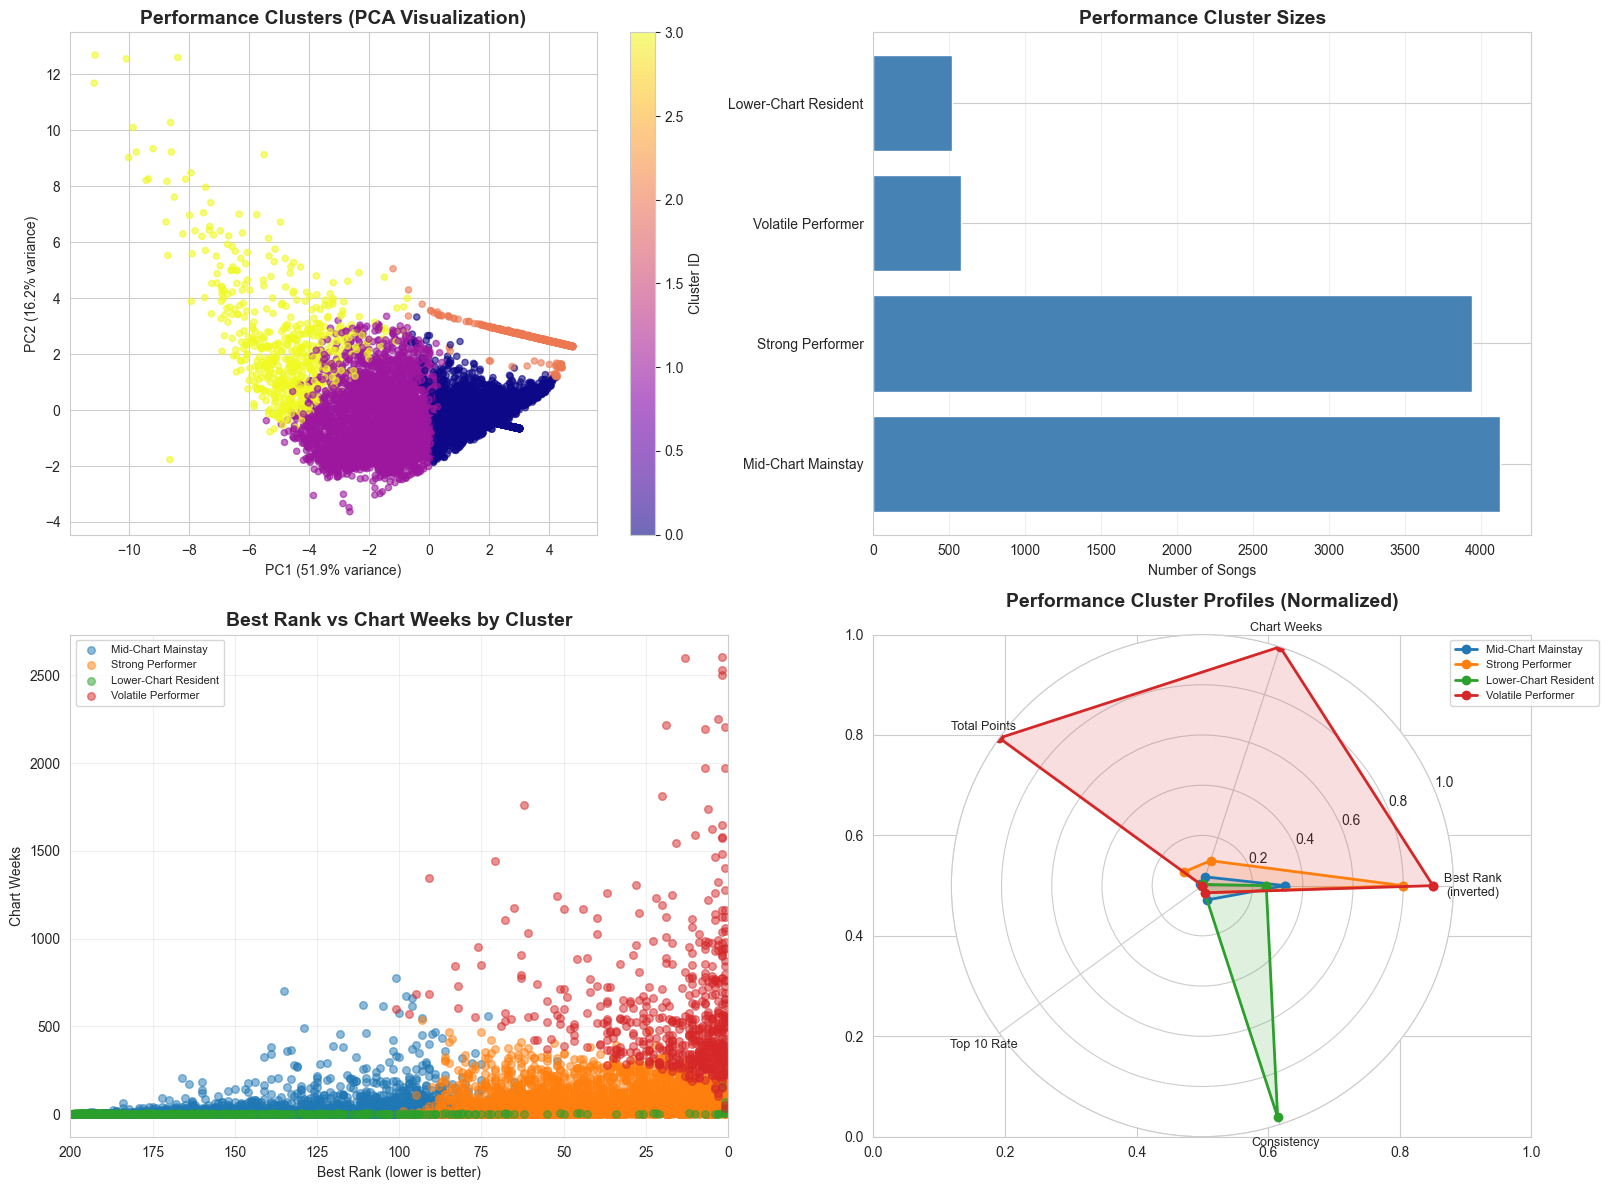

In [32]:
# Reducing dimensions for visualization
pca_perf = PCA(n_components=2, random_state=42)
X_performance_pca = pca_perf.fit_transform(X_performance_scaled)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PCA visualization
scatter = axes[0, 0].scatter(X_performance_pca[:, 0], X_performance_pca[:, 1], 
                             c=performance_features['Performance_Cluster'], 
                             cmap='plasma', alpha=0.6, s=20)
axes[0, 0].set_title('Performance Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca_perf.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_perf.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster ID')

# Plot 2: Cluster size
perf_cluster_sizes = performance_features['Performance_Cluster_Name'].value_counts()
axes[0, 1].barh(range(len(perf_cluster_sizes)), perf_cluster_sizes.values, color='steelblue')
axes[0, 1].set_yticks(range(len(perf_cluster_sizes)))
axes[0, 1].set_yticklabels(perf_cluster_sizes.index)
axes[0, 1].set_title('Performance Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Songs')
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Best Rank vs Chart Weeks by cluster
for cluster_id in range(optimal_k_performance):
    cluster_data = performance_features[performance_features['Performance_Cluster'] == cluster_id]
    axes[1, 0].scatter(cluster_data['Best_Rank'], cluster_data['Chart_Weeks'],
                      label=perf_cluster_names[cluster_id], alpha=0.5, s=30)

axes[1, 0].set_title('Best Rank vs Chart Weeks by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Best Rank (lower is better)')
axes[1, 0].set_ylabel('Chart Weeks')
axes[1, 0].set_xlim(0, 200)
axes[1, 0].invert_xaxis()
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Radar chart of cluster characteristics
categories = ['Best Rank\n(inverted)', 'Chart Weeks', 'Total Points', 'Top 10 Rate', 'Consistency']

# Normalize values for radar chart
norm_profiles = perf_cluster_profiles.copy()
norm_profiles['Norm_Best_Rank'] = 1 - (norm_profiles['Avg_Best_Rank'] / 200)  # Invert and normalize
norm_profiles['Norm_Chart_Weeks'] = norm_profiles['Avg_Chart_Weeks'] / norm_profiles['Avg_Chart_Weeks'].max()
norm_profiles['Norm_Total_Points'] = norm_profiles['Avg_Total_Points'] / norm_profiles['Avg_Total_Points'].max()
norm_profiles['Norm_Top10_Rate'] = norm_profiles['Avg_Top10_Rate']
norm_profiles['Norm_Consistency'] = norm_profiles['Avg_Consistency']

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax = plt.subplot(2, 2, 4, projection='polar')
for cluster_id in range(optimal_k_performance):
    values = [
        norm_profiles.loc[cluster_id, 'Norm_Best_Rank'],
        norm_profiles.loc[cluster_id, 'Norm_Chart_Weeks'],
        norm_profiles.loc[cluster_id, 'Norm_Total_Points'],
        norm_profiles.loc[cluster_id, 'Norm_Top10_Rate'],
        norm_profiles.loc[cluster_id, 'Norm_Consistency']
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=perf_cluster_names[cluster_id])
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9)
ax.set_ylim(0, 1)
ax.set_title('Performance Cluster Profiles (Normalized)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
ax.grid(True)

plt.tight_layout()
plt.savefig('performance_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Save performance features with clusters
performance_features.to_csv('performance_features_with_clusters.csv', index=False)

# Save cluster centroids
centroids_performance = pd.DataFrame(
    scaler_performance.inverse_transform(kmeans_performance.cluster_centers_),
    columns=performance_clustering_features
)
centroids_performance['Cluster_Name'] = centroids_performance.index.map(perf_cluster_names)
centroids_performance.to_csv('performance_cluster_centroids.csv', index=False)

# Save the complete dataframe with both cluster assignments
df.to_csv('spotify_data_with_clusters.csv', index=False)

print("\n Performance clustering results saved!")
print(f"- performance_features_with_clusters.csv")
print(f"- performance_cluster_centroids.csv")
print(f"- spotify_data_with_clusters.csv (main file with both cluster assignments)")


 Performance clustering results saved!
- performance_features_with_clusters.csv
- performance_cluster_centroids.csv
- spotify_data_with_clusters.csv (main file with both cluster assignments)


In [37]:
print("\n" + "="*60)
print("CLUSTER QUALITY VALIDATION")
print("="*60)

# Temporal clusters
temporal_silhouette = silhouette_score(X_temporal_scaled, temporal_features['Temporal_Cluster'])
temporal_db = davies_bouldin_score(X_temporal_scaled, temporal_features['Temporal_Cluster'])

print(f"\nTEMPORAL CLUSTERS (K={optimal_k_temporal}):")
print(f"- Silhouette Score: {temporal_silhouette:.3f} {'Good' if temporal_silhouette > 0.4 else 'Fair' if temporal_silhouette > 0.25 else 'Poor'}")
print(f"- Davies-Bouldin Score: {temporal_db:.3f} (lower is better)")
print(f"- Cluster size balance: {temporal_features['Temporal_Cluster'].value_counts().std():.0f} std dev")

# Performance clusters
performance_silhouette = silhouette_score(X_performance_scaled, performance_features['Performance_Cluster'])
performance_db = davies_bouldin_score(X_performance_scaled, performance_features['Performance_Cluster'])

print(f"\nPERFORMANCE CLUSTERS (K={optimal_k_performance}):")
print(f"- Silhouette Score: {performance_silhouette:.3f} {'Good' if performance_silhouette > 0.4 else 'Fair' if performance_silhouette > 0.25 else 'Poor'}")
print(f"- Davies-Bouldin Score: {performance_db:.3f} (lower is better)")
print(f"- Cluster size balance: {performance_features['Performance_Cluster'].value_counts().std():.0f} std dev")


CLUSTER QUALITY VALIDATION

TEMPORAL CLUSTERS (K=6):
- Silhouette Score: 0.300 Fair
- Davies-Bouldin Score: 1.322 (lower is better)
- Cluster size balance: 1021 std dev

PERFORMANCE CLUSTERS (K=4):
- Silhouette Score: 0.366 Fair
- Davies-Bouldin Score: 0.982 (lower is better)
- Cluster size balance: 2016 std dev



CROSS-CLUSTER ANALYSIS

Cross-Tabulation: Temporal vs Performance Clusters
Performance_Cluster_Name                    Lower-Chart Resident  \
Temporal_Cluster_Name                                              
Early Era (2017-2018) - Summer                               123   
Early Era (2017-2018) - Viral/Quick Peak                     126   
Recent Era (2022-2023) - Sustained Success                     0   
Recent Era (2022-2023) - Winter                                0   
Spring - Friday Fresh                                        143   
Viral/Quick Peak - Winter                                    125   
All                                                          517   

Performance_Cluster_Name                    Mid-Chart Mainstay  \
Temporal_Cluster_Name                                            
Early Era (2017-2018) - Summer                             993   
Early Era (2017-2018) - Viral/Quick Peak                   960   
Recent Era (2022-2023) - Sustained Success     

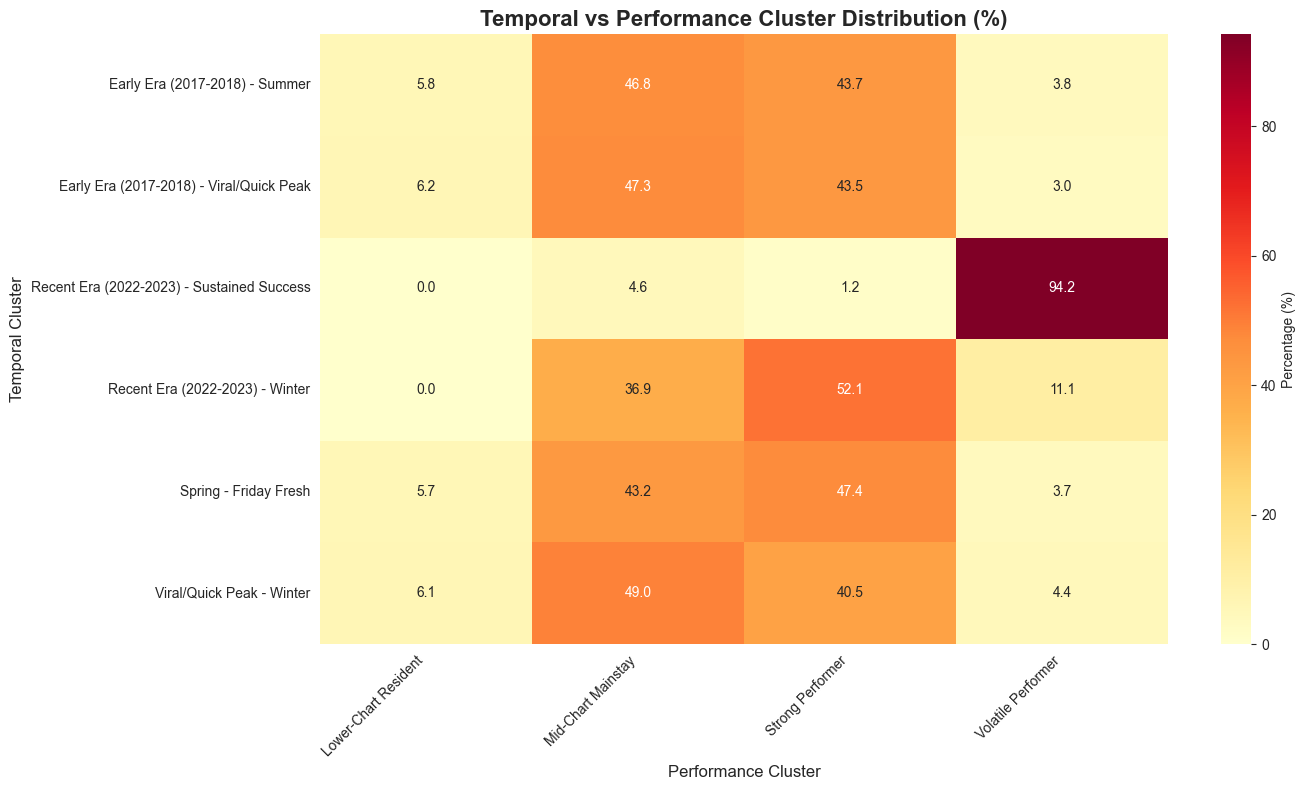


KEY INSIGHTS FROM CROSS-ANALYSIS:
- Early Era (2017-2018) - Viral/Quick Peak: 47.3% are 'Mid-Chart Mainstay'
- Viral/Quick Peak - Winter: 49.0% are 'Mid-Chart Mainstay'
- Early Era (2017-2018) - Summer: 46.8% are 'Mid-Chart Mainstay'
- Recent Era (2022-2023) - Winter: 52.1% are 'Strong Performer'
- Spring - Friday Fresh: 47.4% are 'Strong Performer'
- Recent Era (2022-2023) - Sustained Success: 94.2% are 'Volatile Performer'


In [38]:
print("\n" + "="*60)
print("CROSS-CLUSTER ANALYSIS")
print("="*60)

# Merge both cluster assignments for analysis
cluster_analysis = performance_features[['id', 'Performance_Cluster_Name']].merge(
    temporal_features[['id', 'Temporal_Cluster_Name']],
    on='id',
    how='inner'
)

# Cross-tabulation
cross_tab = pd.crosstab(
    cluster_analysis['Temporal_Cluster_Name'],
    cluster_analysis['Performance_Cluster_Name'],
    margins=True
)

print("\nCross-Tabulation: Temporal vs Performance Clusters")
print(cross_tab)

# Visualize cross-tabulation as heatmap
plt.figure(figsize=(14, 8))
cross_tab_pct = pd.crosstab(
    cluster_analysis['Temporal_Cluster_Name'],
    cluster_analysis['Performance_Cluster_Name'],
    normalize='index'
) * 100

sns.heatmap(cross_tab_pct, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'})
plt.title('Temporal vs Performance Cluster Distribution (%)', fontsize=16, fontweight='bold')
plt.xlabel('Performance Cluster', fontsize=12)
plt.ylabel('Temporal Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cluster_crosstab_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Find interesting patterns
print("\nKEY INSIGHTS FROM CROSS-ANALYSIS:")
for temp_cluster in cluster_analysis['Temporal_Cluster_Name'].unique():
    temp_data = cluster_analysis[cluster_analysis['Temporal_Cluster_Name'] == temp_cluster]
    dominant_perf = temp_data['Performance_Cluster_Name'].mode()[0]
    pct = (temp_data['Performance_Cluster_Name'] == dominant_perf).mean() * 100
    print(f"- {temp_cluster}: {pct:.1f}% are '{dominant_perf}'")

In [39]:
print("\n" + "="*60)
print("CLUSTERING SUMMARY REPORT")
print("="*60)

summary_report = f"""
DATA OVERVIEW:
- Total songs analyzed: {len(df):,}
- Unique songs: {df['id'].nunique():,}
- Date range: {df['Date'].min().date()} to {df['Date'].max().date()}

TEMPORAL CLUSTERING:
- Number of clusters: {optimal_k_temporal}
- Silhouette Score: {temporal_silhouette:.3f}
- Davies-Bouldin Score: {temporal_db:.3f}
- Largest cluster: {temporal_features['Temporal_Cluster_Name'].value_counts().index[0]} ({temporal_features['Temporal_Cluster_Name'].value_counts().values[0]:,} songs)
- Smallest cluster: {temporal_features['Temporal_Cluster_Name'].value_counts().index[-1]} ({temporal_features['Temporal_Cluster_Name'].value_counts().values[-1]:,} songs)

PERFORMANCE CLUSTERING:
- Number of clusters: {optimal_k_performance}
- Silhouette Score: {performance_silhouette:.3f}
- Davies-Bouldin Score: {performance_db:.3f}
- Largest cluster: {performance_features['Performance_Cluster_Name'].value_counts().index[0]} ({performance_features['Performance_Cluster_Name'].value_counts().values[0]:,} songs)
- Smallest cluster: {performance_features['Performance_Cluster_Name'].value_counts().index[-1]} ({performance_features['Performance_Cluster_Name'].value_counts().values[-1]:,} songs)

FILES GENERATED:
temporal_features_with_clusters.csv
temporal_cluster_centroids.csv
performance_features_with_clusters.csv
performance_cluster_centroids.csv
spotify_data_with_clusters.csv
Multiple visualization PNG files

NEXT STEPS:
1. Review cluster names and characteristics
2. Use these cluster assignments as meta-features for prediction tasks
3. Implement additional clustering dimensions (audio, artist tier, network, etc.)
4. Build prediction models using cluster memberships
"""

print(summary_report)

# Save report
with open('clustering_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\nSummary report saved to 'clustering_summary_report.txt'")


CLUSTERING SUMMARY REPORT

DATA OVERVIEW:
- Total songs analyzed: 651,936
- Unique songs: 9,161
- Date range: 2017-01-01 to 2023-05-29

TEMPORAL CLUSTERING:
- Number of clusters: 6
- Silhouette Score: 0.300
- Davies-Bouldin Score: 1.322
- Largest cluster: Spring - Friday Fresh (2,512 songs)
- Smallest cluster: Recent Era (2022-2023) - Winter (217 songs)

PERFORMANCE CLUSTERING:
- Number of clusters: 4
- Silhouette Score: 0.366
- Davies-Bouldin Score: 0.982
- Largest cluster: Mid-Chart Mainstay (4,127 songs)
- Smallest cluster: Lower-Chart Resident (517 songs)

FILES GENERATED:
temporal_features_with_clusters.csv
temporal_cluster_centroids.csv
performance_features_with_clusters.csv
performance_cluster_centroids.csv
spotify_data_with_clusters.csv
Multiple visualization PNG files

NEXT STEPS:
1. Review cluster names and characteristics
2. Use these cluster assignments as meta-features for prediction tasks
3. Implement additional clustering dimensions (audio, artist tier, network, etc.)
4